In [1]:
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from scipy.io import loadmat

import os
import matplotlib.pyplot as plt


torch.manual_seed(17)


base_dir = '/kaggle/input/svhndataset'


extra = loadmat(os.path.join(base_dir,'extra_32x32.mat'))
test = loadmat(os.path.join(base_dir,'test_32x32.mat'))
train = loadmat(os.path.join(base_dir,'train_32x32.mat'))


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.device(device)

print(f"Available Device: {device}")

Available Device: cuda:0


In [2]:
batch_size = 64
class MatDataset(Dataset):
    def __init__(self,ds_file,transform=None):
        
        images_default = ds_file['X']
        images_transposed = np.transpose(images_default,(3,0,1,2))
        
        
        self.transform = transform
        self.length = len(images_transposed)
        
        self.tensor_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((32,40),antialias=True)])
        self.images = self._alter_images(images_transposed) # transform images prior to training
        
        
        
        labels_default = ds_file['y']
        self.labels = self._alter_targets(labels_default)
    
        
    def __len__(self,):
        return self.length
    
    def __getitem__(self,idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        label = torch.tensor(label)
        
        return image, label
    
    def _alter_targets(self,targets):
        for idx in range(self.__len__()):
            if targets[idx] == 10:
                targets[idx] = 0
            
        return targets
    
    def _alter_images(self,images):
        processed_images = torch.zeros((self.length,3,32,40))
        for idx in range(self.__len__()):

            image = images[idx]
            image = self.tensor_transform(image)

            if self.transform:
                image = self.transform(image)

            processed_images[idx] = image


        return processed_images
                
    

In [3]:
def combine_train_extra(train,extra):
    train_images = train['X']
    train_labels = train['y']

    extra_images = extra['X']
    extra_labels = extra['y']
    
    train_images = np.transpose(train_images, (3, 0, 1, 2))
    extra_images = np.transpose(extra_images, (3, 0, 1, 2))

    combined_images = np.concatenate((train_images, extra_images), axis=0)
    combined_labels = np.concatenate((train_labels, extra_labels), axis=0)


    combined_labels[combined_labels == 10] = 0
    
    return combined_images,combined_labels

In [9]:
class LargeTrainDataset(Dataset):
    def __init__(self,images,labels,transform=None):
        
        self.labels=labels
        
        self.images=images
        
        self.transform = transform
        
        self.tensor_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((32,40),antialias=True)])

    def __len__(self,):
        return len(self.labels)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        label = self.labels[idx][0]
        
        image = self._alter_image(image)
        label = torch.tensor(label)
        
        return image, label
    
    def _alter_image(self,image):
        
        image = self.tensor_transform(image)

        if self.transform:
            image = self.transform(image)

        return image
                

In [10]:
train_images,train_labels = combine_train_extra(train,extra)

In [11]:
train_transforms = transforms.RandomApply(nn.ModuleList([
    transforms.RandomRotation((0,70)),
    transforms.RandomVerticalFlip(p=0.2),
    #transforms.RandomAffine((0,60)),
]), p=0.7)

scripted_transforms = torch.jit.script(train_transforms)


# train_dataset = MatDataset(train, transform=scripted_transforms)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# extra_dataset = MatDataset(extra, transform=scripted_transforms)
# extra_loader = DataLoader(extra_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

large_dataset = LargeTrainDataset(train_images,train_labels, transform=scripted_transforms)
train_loader = DataLoader(large_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = MatDataset(test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)



In [12]:
def visualize_images(data_loader):
    
    images,labels = next(iter(data_loader))
    
    fig, axes = plt.subplots(1, batch_size//8, figsize=(16, 2))
    axes = axes.flatten()

    for img,lbl, ax in zip(images[:batch_size//8],labels[:batch_size//8], axes):
        img = img.permute(1,2,0)
        ax.imshow(img.cpu())
        ax.set_title(lbl.item())
        ax.axis('tight')
        ax.axis('off')


    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()
    

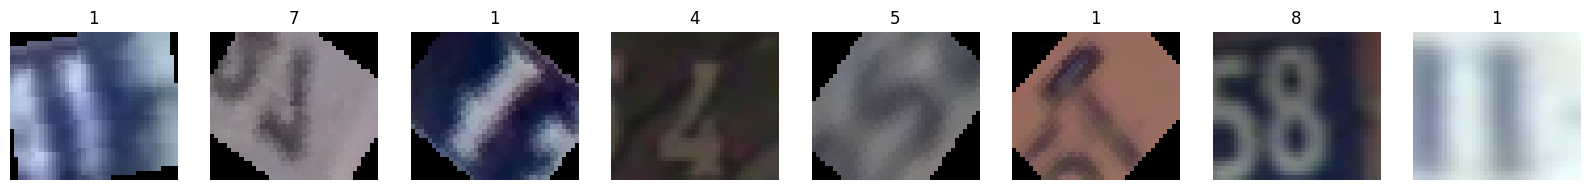

In [13]:
visualize_images(train_loader)

In [14]:

class CustomModel(nn.Module):
    def __init__(self,input_channels=3):
        super(CustomModel, self).__init__()

        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
          
        )
                
        self.fc = nn.Sequential(
            nn.Linear(5*4*512,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
        )
        
        

    def forward(self, x):
        conv = self.conv(x)
        conv = conv.view(conv.size(0),-1)
        return self.fc(conv)


In [15]:
model = CustomModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [16]:
import time

def train_single_batch(model, num_epochs,optimizer):
    images,labels = next(iter(train_loader))
    labels = labels.view(-1)

    for epoch in range(num_epochs):
        start = time.time()
        
        model.train()
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        outputs = model(images) # 64x10
        
        loss = loss_fn(outputs, labels)
        
            
        loss.backward()
        optimizer.step()
    
        
        end_train = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train Time: {end_train-start:.4f}")


In [17]:
train_single_batch(model,60,optimizer)

Epoch [1/60], Loss: 2.3025, Train Time: 0.9161
Epoch [2/60], Loss: 2.2007, Train Time: 0.0073
Epoch [3/60], Loss: 2.1083, Train Time: 0.0038
Epoch [4/60], Loss: 2.0107, Train Time: 0.0036
Epoch [5/60], Loss: 1.8875, Train Time: 0.0036
Epoch [6/60], Loss: 1.7628, Train Time: 0.0035
Epoch [7/60], Loss: 1.6322, Train Time: 0.0034
Epoch [8/60], Loss: 1.4878, Train Time: 0.0033
Epoch [9/60], Loss: 1.3442, Train Time: 0.0033
Epoch [10/60], Loss: 1.1966, Train Time: 0.0033
Epoch [11/60], Loss: 1.0477, Train Time: 0.0036
Epoch [12/60], Loss: 0.9057, Train Time: 0.0034
Epoch [13/60], Loss: 0.7695, Train Time: 0.0034
Epoch [14/60], Loss: 0.6403, Train Time: 0.0033
Epoch [15/60], Loss: 0.5239, Train Time: 0.0035
Epoch [16/60], Loss: 0.4174, Train Time: 0.0033
Epoch [17/60], Loss: 0.3241, Train Time: 0.0037
Epoch [18/60], Loss: 0.2456, Train Time: 0.0035
Epoch [19/60], Loss: 0.1822, Train Time: 0.0035
Epoch [20/60], Loss: 0.1327, Train Time: 0.0034
Epoch [21/60], Loss: 0.0954, Train Time: 0.0037
E

In [18]:
model = CustomModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [19]:
def train(model, num_epochs,optimizer,loss_fn):

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_train = 0.0
        total_train=0.0
        start = time.time()
        for images,labels in train_loader:

            model.train()

            images, labels = images.to(device), labels.to(device)
            labels = labels.view(-1)
            
            optimizer.zero_grad(set_to_none=True)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            
            epoch_loss+=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train+=labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()


        end_train = time.time()
            
        model.eval()
        val_loss = 0.0
        correct_val = 0.0
        total_val = 0.0
        
        
        with torch.no_grad():
            for images,labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                labels = labels.view(-1)
    
                outputs = model(images)
                
                loss=loss_fn(outputs,labels)
                
                val_loss+=loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val+=labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
            
        end_val = time.time()
        
        val_loss/=len(test_loader)
        correct_val /= total_val
        
        correct_train /= total_train
        epoch_loss/=len(train_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train Acc: {correct_train:.4f}, Train Time: {end_train-start:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct_val:.4f}, Inference Time: {end_val-end_train:.4f}")

In [20]:
train(model, 10,optimizer,loss_fn)

Epoch [1/10], Loss: 0.2396, Train Acc: 0.8957, Train Time: 146.6935, Val Loss: 0.3289, Val Acc: 0.9040, Inference Time: 1.8870
Epoch [2/10], Loss: 0.1976, Train Acc: 0.9505, Train Time: 147.1375, Val Loss: 0.2252, Val Acc: 0.9380, Inference Time: 1.7852
Epoch [3/10], Loss: 0.1360, Train Acc: 0.9597, Train Time: 148.0003, Val Loss: 0.2125, Val Acc: 0.9407, Inference Time: 1.7410
Epoch [4/10], Loss: 0.1304, Train Acc: 0.9645, Train Time: 139.1594, Val Loss: 0.2143, Val Acc: 0.9394, Inference Time: 1.7330
Epoch [5/10], Loss: 0.1931, Train Acc: 0.9682, Train Time: 139.3747, Val Loss: 0.1840, Val Acc: 0.9487, Inference Time: 1.7193
Epoch [6/10], Loss: 0.0919, Train Acc: 0.9703, Train Time: 140.4507, Val Loss: 0.1759, Val Acc: 0.9520, Inference Time: 1.7203
Epoch [7/10], Loss: 0.1109, Train Acc: 0.9723, Train Time: 139.9499, Val Loss: 0.1657, Val Acc: 0.9564, Inference Time: 1.7909
Epoch [8/10], Loss: 0.1656, Train Acc: 0.9738, Train Time: 139.4684, Val Loss: 0.1623, Val Acc: 0.9564, Inferen

In [21]:
torch.save(model, "base_model3.pt")